<a href="https://colab.research.google.com/github/juliannadesalle/Alzheimer-s-Detection-in-MRI-Images---5106/blob/main/Alzheimers_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Run to reset all data
!rm -rf /content/Dataset/
!unzip /content/drive/MyDrive/archive.zip 

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Non_Demented/non_1395.jpg  
  inflating: Dataset/Non_Demented/non_1396.jpg  
  inflating: Dataset/Non_Demented/non_1397.jpg  
  inflating: Dataset/Non_Demented/non_1398.jpg  
  inflating: Dataset/Non_Demented/non_1399.jpg  
  inflating: Dataset/Non_Demented/non_14.jpg  
  inflating: Dataset/Non_Demented/non_140.jpg  
  inflating: Dataset/Non_Demented/non_1400.jpg  
  inflating: Dataset/Non_Demented/non_1401.jpg  
  inflating: Dataset/Non_Demented/non_1402.jpg  
  inflating: Dataset/Non_Demented/non_1403.jpg  
  inflating: Dataset/Non_Demented/non_1404.jpg  
  inflating: Dataset/Non_Demented/non_1405.jpg  
  inflating: Dataset/Non_Demented/non_1406.jpg  
  inflating: Dataset/Non_Demented/non_1407.jpg  
  inflating: Dataset/Non_Demented/non_1408.jpg  
  inflating: Dataset/Non_Demented/non_1409.jpg  
  inflating: Dataset/Non_Demented/non_141.jpg  
  inflating: Dataset/Non_Demented/non_1410.jpg  
  inflating: Dataset/N

In [ ]:
import os
import pathlib
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

#printout of data folders labels
dirct = os.listdir("/content/Dataset/") 
data_dir = pathlib.Path(os.path.join("/content/Dataset/"+str(dirct[0])))
dirct

['Mild_Demented', 'Non_Demented', 'Moderate_Demented', 'Very_Mild_Demented']

In [ ]:
import pandas as pd

#creating Dataframes and loading each folder to it along with a label 
train_df0 = pd.DataFrame(columns=["img_name","label"])
train_df1 = pd.DataFrame(columns=["img_name","label"])
train_df2 = pd.DataFrame(columns=["img_name","label"])
train_df3 = pd.DataFrame(columns=["img_name","label"])

train_df0["img_name"]= os.listdir(pathlib.Path(os.path.join("/content/Dataset/Very_Mild_Demented")))
train_df0["label"]= 0


train_df1["img_name"]= os.listdir(pathlib.Path(os.path.join("/content/Dataset/Non_Demented")))
train_df1["label"]= 1


train_df2["img_name"]= os.listdir(pathlib.Path(os.path.join("/content/Dataset/Moderate_Demented")))
train_df2["label"]= 2


train_df3["img_name"]= os.listdir(pathlib.Path(os.path.join("/content/Dataset/Mild_Demented")))
train_df3["label"]= 3


In [ ]:
#Combining all dataframes to one
new=train_df0.append(train_df1, ignore_index=True)
new=new.append(train_df2, ignore_index=True)
new=new.append(train_df3, ignore_index=True)

In [ ]:
#View of total dataframe
new

,img_name,label
0,verymild_688.jpg,0
1,verymild_1486.jpg,0
2,verymild_868.jpg,0
3,verymild_1904.jpg,0
4,verymild_221.jpg,0
...,...,...
6395,mild_107.jpg,3
6396,mild_342.jpg,3
6397,mild_291.jpg,3
6398,mild_469.jpg,3


In [ ]:
#converting total dataframe to csv for indexing in dataloader
new.to_csv (r'train_csv.csv', index = False, header=True)

In [ ]:
#combining all data into one folder for indexing in the dataloader 
import shutil

# Function to create new folder if not exists
def make_new_folder(folder_name, parent_folder):
	
	# Path
	path = os.path.join(parent_folder, folder_name)
	
	# Create the folder
	# 'new_folder' in
	# parent_folder
	try:
		# mode of the folder
		mode = 0o777

		# Create folder
		os.mkdir(path, mode)
	except OSError as error:
		print(error)

# current folder path
current_folder = "/content/Dataset"

# list of folders to be merged
list_dir = dirct

# enumerate on list_dir to get the
# content of all the folders ans store
# it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
	path = os.path.join(current_folder, val)
	content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will
# be merged
merge_folder = "merge_folder"

# merge_folder path - current_folder
# + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

	# loop through the contents of the
	# list of folders
	for contents in content_list[sub_dir]:
		# make the path of the content to move
		path_to_content = sub_dir + "/" + contents

		# make the path with the current folder
		dir_to_move = os.path.join(current_folder, path_to_content )

		# move the file
		shutil.move(dir_to_move, merge_folder_path)

  
for sub_dir in content_list:
  if len(os.listdir("/content/Dataset/"+sub_dir)) == 0: # Check if the folder is empty
    os.rmdir("/content/Dataset/"+sub_dir)

In [ ]:
#Custom dataloader class
from torch.utils.data import Dataset, DataLoader
class Alzheimers_Dataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [ ]:
import torch
#Dataloader parameters
batch_size = 32
pin_memory = True #This lets your DataLoader allocate the samples in page-locked memory, which speeds-up host to device transfer
num_workers = 1 #keep increasing till models throughput stops increasing 

# Device configuration
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
import torchvision.transforms as transforms
from PIL import Image
crop_size=110 #original 128 * 128, cropped empty space away
img_resize=224 #new size

#Finding mean and std of entire dataset
dataset = Alzheimers_Dataset("/content/Dataset/merge_folder",
                             annotation_file="train_csv.csv",
                             transform= transforms.Compose([
                                    transforms.CenterCrop((crop_size, crop_size)), #original is 128 * 128
                                    transforms.Resize((img_resize, img_resize)), #new size
                                    transforms.Grayscale(num_output_channels=1), #3 channel to 1
                                    transforms.ToTensor(),
                                     ])#close transform
                            )#close dataset
all_data=DataLoader(dataset=dataset, shuffle=False, batch_size=6400,num_workers=num_workers,pin_memory=pin_memory)

mean = 0.0
for images, _ in all_data:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(all_data.dataset)

var = 0.0
for images, _ in all_data:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(all_data.dataset)*128*128))

print("STD: ",std)
print("Mean: ", mean)

STD:  tensor([0.5673])
Mean:  tensor([0.3772])


In [ ]:
#Creating dataloader for training, validation and testing(uses mean and std from above)
dataset = Alzheimers_Dataset("/content/Dataset/merge_folder",
                             annotation_file="train_csv.csv",
                             transform= transforms.Compose([                               
                                    transforms.CenterCrop((crop_size, crop_size)), #original is 128 * 128, cropped empty space away
                                    transforms.Resize((img_resize, img_resize)), #resized to 224 * 224
                                    transforms.Grayscale(num_output_channels=1), #3 RGB channel to 1 Greyscale
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mean, std=std)#std and mean found above
                                ])#close transform
                            )#close dataset

train_set, validation_set, test_set = torch.utils.data.random_split(dataset,[5440,640,320])


train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)
val_loader = DataLoader(dataset=validation_set, shuffle=False, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(dataset=test_set, shuffle=False, batch_size=320,num_workers=num_workers, pin_memory=pin_memory)

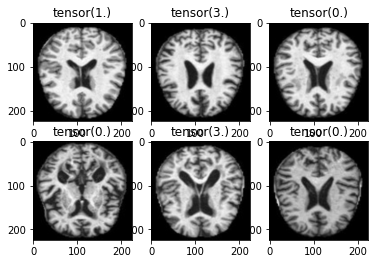

In [ ]:
import matplotlib.pyplot as plt
#Testing Dataloader
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.gca().set_title(str(example_targets[i]))
plt.show()

In [ ]:
#Training Dataloader information 
dataiter = iter(train_loader)
images, labels = dataiter.next()
print("DataLoader Specs:")
print("Data Type", type(images))
print("Data Size(batch, channel, x ,y):", images.shape)

DataLoader Specs:
Data Type <class 'torch.Tensor'>
Data Size(batch, channel, x ,y): torch.Size([32, 1, 224, 224])


In [ ]:
import torch.nn as nn
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

In [ ]:
# Hyper-parameters 
input_size = img_resize**2 # 128*128
hidden_size = 500 
num_classes = 4

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [ ]:
import datetime

# Train the model
num_epochs = 10
learning_rate = 0.001
start_time=datetime.datetime.now()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        images = images.reshape(-1, img_resize**2).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.long())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            
            
            # Validate the model
            # In validate phase, we don't need to compute gradients (for memory efficiency)
            with torch.no_grad():
                acc=0
                n_correct = 0
                n_samples = 0
                for images, labels in val_loader:
                    images = images.reshape(-1, img_resize**2).to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    # max returns (value ,index)
                    _, predicted = torch.max(outputs.data, 1)
                    n_samples += labels.size(0)
                    n_correct += (predicted == labels).sum().item()

                acc = 100.0 * n_correct / n_samples
                print (f'Epoch [{epoch+1}/{num_epochs}], Time: {datetime.datetime.now()-start_time} , Val Acc: {acc} %,  Loss: {loss.item():.4f}')
            

Epoch [1/10], Time: 0:00:07.573101 , Val Acc: 62.96875 %,  Loss: 1.2728
Epoch [2/10], Time: 0:00:19.333368 , Val Acc: 70.0 %,  Loss: 0.7614
Epoch [3/10], Time: 0:00:31.195267 , Val Acc: 77.03125 %,  Loss: 0.4092
Epoch [4/10], Time: 0:00:43.116319 , Val Acc: 66.875 %,  Loss: 0.6068
Epoch [5/10], Time: 0:00:55.309399 , Val Acc: 76.71875 %,  Loss: 0.1886
Epoch [6/10], Time: 0:01:07.118124 , Val Acc: 76.71875 %,  Loss: 0.1396
Epoch [7/10], Time: 0:01:19.262231 , Val Acc: 77.1875 %,  Loss: 0.2275


KeyboardInterrupt: ignored

In [ ]:
# Validate the model
# In validate phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    acc=0
    n_correct = 0
    n_samples = 0
    for images, labels in val_loader:
        images = images.reshape(-1, img_resize**2).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the {len(val_loader)} validation batch images: {acc} %')

In [ ]:
#Something in here fixes the error when plotting from the dataloader 

# from __future__ import print_function, division
# import os
# import torch
# import pandas as pd
# from skimage import io, transform
# import numpy as np
# import matplotlib.pyplot as plt
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms, utils
# import pandas as pd
# import os
# import torch
# from torch.utils.data import Dataset
# from PIL import Image
# import torchvision.models as models
# import torch.nn as nn
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms
# from torchvision import datasets
# from torchvision.transforms import ToTensor
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import os 
# import pathlib
# import glob
# import os
# import torch
# import torch.nn as nn
# import torchvision
# import matplotlib.pyplot as plt
# import pathlib
# import pandas as pd

# Training the network

In [ ]:
import time
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
sns.set()
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
## Progress bar
from tqdm.notebook import tqdm
#from ptflops import get_model_complexity_info

In [ ]:
import torch
print("Using torch", torch.__version__)

Using torch 1.11.0+cu113


In [ ]:
torch.manual_seed(42) # Setting the seed

In [ ]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name())
    print("Memory Usage:")
    print("\tAllocated:", round(torch.cuda.memory_allocated()/1024**3,1), "GB")
    print("\tCached:", round(torch.cuda.memory_reserved()/1024**3,1), "GB")

Tesla P100-PCIE-16GB
Memory Usage:
	Allocated: 0.4 GB
	Cached: 0.6 GB


TRAINING OR EVALUATING

In [ ]:
TRAINING1=False # ResNet
TRAINING2=False # GoogleNet
TRAINING3=False # DenseNet
TRAINING4=False # MobileNetV3Large

In [ ]:
class ResBlock(nn.Module):
    def __init__(self,n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [ ]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(1, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear(32*32*n_chans1, 32)
        self.fc2 = nn.Linear(32,4)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 32 * 32 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_load, val_load, load_checkpoint=False, path=None):
    start = 1
    if load_checkpoint and path is not None:
      try:
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        last_epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        start = last_epoch+1
      except:
        None
    model.train()
    temp_t = []
    temp_v = []
    tic = time.time()
    for epoch in tqdm(range(start, n_epochs + 1)):
        total = 0
        correct = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.type(torch.long).to(device)
        
            batch_size = imgs.shape[0]
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            model.eval()
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
        
                batch_size = imgs.shape[0]
                outputs = model(imgs)
                _, predicted = torch.max(outputs,dim=1)
                total += labels.shape[0]
                correct += int((predicted==labels).sum())
        model.train()
        if epoch % 10 == 0:
            print("Epoch %d, Train Loss: %f, Val Accuracy: %f" % (epoch, float(loss), float(correct/total)))
        if epoch % 50 == 0 and path is not None:
            print("Creating checkpoint")
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path)
        temp_t.append(float(loss))
        temp_v.append(float(correct/total))
    print("Time to complete training: %f" % float(time.time()-tic))
    fig = plt.figure(dpi=600)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(range(1,n_epochs+1), temp_t, 'ro')
    fig2 = plt.figure(dpi=600)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(range(1,n_epochs+1), temp_v,'bo')

In [ ]:
def training_loopG(n_epochs, optimizer, model, loss_fn, train_load, val_load, load_checkpoint=False, path=None):
    start = 1
    if load_checkpoint and path is not None:
      try:
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        last_epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        start = last_epoch+1
      except:
        None
    model.train()
    temp_t = []
    temp_v = []
    tic = time.time()
    for epoch in tqdm(range(start, n_epochs + 1)):
        total = 0
        correct = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.type(torch.long).to(device)
        
            batch_size = imgs.shape[0]
            outputs = model(imgs)
            loss = loss_fn(outputs[0], labels)
            loss2 = loss_fn(outputs[1], labels)
            loss1 = loss_fn(outputs[2], labels)

            loss = loss + 0.3*(loss2+loss1)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            model.eval()
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
        
                batch_size = imgs.shape[0]
                outputs = model(imgs)
                _, predicted = torch.max(outputs,dim=1)
                total += labels.shape[0]
                correct += int((predicted==labels).sum())
        model.train()
        if epoch % 10 == 0:
            print("Epoch %d, Train Loss: %f, Val Accuracy: %f" % (epoch, float(loss), float(correct/total)))
        if epoch % 50 == 0 and path is not None:
            print("Creating checkpoint")
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path)
        temp_t.append(float(loss))
        temp_v.append(float(correct/total))
    print("Time to complete training: %f" % float(time.time()-tic))
    fig = plt.figure(dpi=600)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(range(1,n_epochs+1), temp_t, 'ro')
    fig2 = plt.figure(dpi=600)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(range(1,n_epochs+1), temp_v,'bo')

Time to complete inference: 1.177871


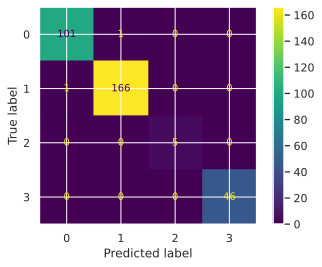

In [ ]:
n_chans = 32
n_block = 50

# "Transfer learning" (It's not really transfer learning since it's learning everything anyway)
# Takes in the pre-modeled ResNet-50 and changes the FC layer to have 4 outputs
ResNet50 = torchvision.models.resnet50(pretrained=False)
res50FcIn = ResNet50.fc.in_features
ResNet50.fc = nn.Linear(res50FcIn, 4)
ResNet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
ResNet50 = ResNet50.to(device)

# Original implementation
#ResNet50 = NetResDeep(n_chans1=n_chans,n_blocks=n_block).to(device)
checkpoint_path = "/content/drive/MyDrive/ResNet"+str(n_block)+"checkpoint_SGD.pt"
if TRAINING1 is True:
    optimizer = optim.SGD(ResNet50.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss().to(device)

    training_loop(
        n_epochs=200,
        optimizer=optimizer,
        model=ResNet50,
        loss_fn=loss_fn,
        train_load=train_loader,
        val_load=val_loader,
        load_checkpoint=False,
        path=checkpoint_path
    )

    ResNet50.eval()
    gt_array = []
    pred_array = []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = ResNet50(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)

    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()
    state_dict = ResNet50.state_dict()
    torch.save(state_dict, "/content/drive/MyDrive/ResNet"+str(n_block)+"_SGD.tar")
import sklearn.metrics
if TRAINING1 is False:
    state_dict = torch.load("/content/drive/MyDrive/ResNet"+str(n_block)+"_SGD.tar")
    ResNet50.load_state_dict(state_dict)
    
    ResNet50.eval()
    gt_array = []
    pred_array = []
    tic = time.time()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = ResNet50(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)
    print("Time to complete inference: %f" % float(time.time()-tic))
    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()

/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:50: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 10, Train Loss: 0.341380, Val Accuracy: 0.960938
Epoch 20, Train Loss: 0.120893, Val Accuracy: 0.959375
Epoch 30, Train Loss: 0.073152, Val Accuracy: 0.976562
Epoch 40, Train Loss: 0.023156, Val Accuracy: 0.979688
Epoch 50, Train Loss: 0.009619, Val Accuracy: 0.984375
Creating checkpoint
Epoch 60, Train Loss: 0.017594, Val Accuracy: 0.987500
Epoch 70, Train Loss: 0.023888, Val Accuracy: 0.982812
Epoch 80, Train Loss: 0.003971, Val Accuracy: 0.982812
Epoch 90, Train Loss: 0.003469, Val Accuracy: 0.985938
Epoch 100, Train Loss: 0.002914, Val Accuracy: 0.984375
Creating checkpoint
Epoch 110, Train Loss: 0.002828, Val Accuracy: 0.981250
Epoch 120, Train Loss: 0.008753, Val Accuracy: 0.987500
Epoch 130, Train Loss: 0.001003, Val Accuracy: 0.990625
Epoch 140, Train Loss: 0.006570, Val Accuracy: 0.982812
Epoch 150, Train Loss: 0.000768, Val Accuracy: 0.985938
Creating checkpoint
Epoch 160, Train Loss: 0.001304, Val Accuracy: 0.982812
Epoch 170, Train Loss: 0.002968, Val Accuracy: 0.9875

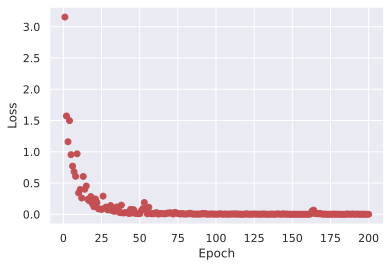

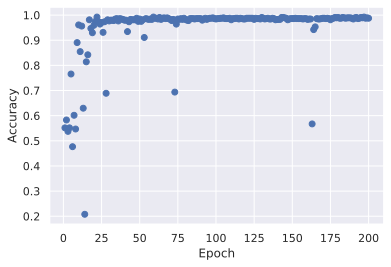

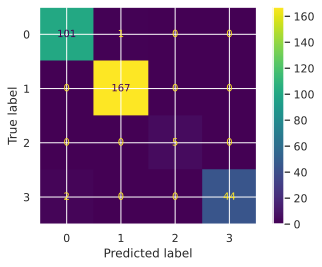

In [ ]:
GoogleNet = torchvision.models.googlenet(pretrained=False)
FcIn = GoogleNet.fc.in_features
GoogleNet.fc = nn.Linear(FcIn, 4)
GoogleNet.conv1.conv = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
GoogleNet = GoogleNet.to(device)

checkpoint_path = "/content/drive/MyDrive/GoogleNetcheckpoint_SGD.pt"
if TRAINING2 is True:
    optimizer = optim.SGD(GoogleNet.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss().to(device)

    training_loopG(
        n_epochs=200,
        optimizer=optimizer,
        model=GoogleNet,
        loss_fn=loss_fn,
        train_load=train_loader,
        val_load=val_loader,
        load_checkpoint=False,
        path=checkpoint_path
    )

    GoogleNet.eval()
    gt_array = []
    pred_array = []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = GoogleNet(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)
    
    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()
    state_dict = GoogleNet.state_dict()
    torch.save(state_dict, "/content/drive/MyDrive/GoogleNet_SGD.tar")
    
if TRAINING2 is False:
    state_dict = torch.load("/content/drive/MyDrive/GoogleNet_SGD.tar")
    GoogleNet.load_state_dict(state_dict)
    
    GoogleNet.eval()
    gt_array = []
    pred_array = []
    tic = time.time()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = GoogleNet(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)
    print("Time to complete inference: %f" % float(time.time()-tic))
    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()

Time to complete inference: 1.419028


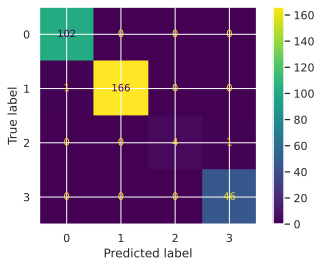

In [ ]:
DenseNet = torchvision.models.densenet161(pretrained=False)
FcIn = DenseNet.classifier.in_features
DenseNet.classifier = nn.Linear(FcIn, 4)
DenseNet.features.conv0 = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
DenseNet = DenseNet.to(device)

checkpoint_path = "/content/drive/MyDrive/DenseNetcheckpoint_SGD.pt"
if TRAINING3 is True:
    optimizer = optim.SGD(DenseNet.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss().to(device)

    training_loop(
        n_epochs=200,
        optimizer=optimizer,
        model=DenseNet,
        loss_fn=loss_fn,
        train_load=train_loader,
        val_load=val_loader,
        load_checkpoint=False,
        path=checkpoint_path
    )

    DenseNet.eval()
    gt_array = []
    pred_array = []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = DenseNet(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)

    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()
    state_dict = DenseNet.state_dict()
    torch.save(state_dict, "/content/drive/MyDrive/DenseNet_SGD.tar")
    
if TRAINING3 is False:
    state_dict = torch.load("/content/drive/MyDrive/DenseNet_SGD.tar")
    DenseNet.load_state_dict(state_dict)
    
    DenseNet.eval()
    gt_array = []
    pred_array = []
    tic = time.time()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = DenseNet(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)
    print("Time to complete inference: %f" % float(time.time()-tic))
    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()

Time to complete inference: 0.934165


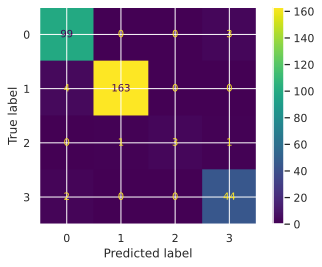

In [ ]:
MobileNetV3Large = torchvision.models.mobilenet_v3_large(pretrained=False)
FcIn = MobileNetV3Large.classifier[3].in_features
MobileNetV3Large.classifier[3] = nn.Linear(FcIn, 4)
MobileNetV3Large.features[0][0] = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
MobileNetV3Large = MobileNetV3Large.to(device)

checkpoint_path = "/content/drive/MyDrive/MobileNetV3Largecheckpoint_SGD.pt"
if TRAINING4 is True:
    optimizer = optim.SGD(MobileNetV3Large.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss().to(device)

    training_loop(
        n_epochs=200,
        optimizer=optimizer,
        model=MobileNetV3Large,
        loss_fn=loss_fn,
        train_load=train_loader,
        val_load=val_loader,
        load_checkpoint=False,
        path=checkpoint_path
    )

    MobileNetV3Large.eval()
    gt_array = []
    pred_array = []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = MobileNetV3Large(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)

    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()
    state_dict = MobileNetV3Large.state_dict()
    torch.save(state_dict, "/content/drive/MyDrive/MobileNetV3Large_SGD.tar")
    
if TRAINING4 is False:
    state_dict = torch.load("/content/drive/MyDrive/MobileNetV3Large_SGD.tar")
    MobileNetV3Large.load_state_dict(state_dict)
    
    MobileNetV3Large.eval()
    gt_array = []
    pred_array = []
    tic = time.time()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = MobileNetV3Large(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)
    print("Time to complete inference: %f" % float(time.time()-tic))
    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()

In [ ]:
GoogleNet.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        batch_size = imgs.shape[0]
        outputs = GoogleNet(imgs)
    print((outputs))

tensor([[-2.8143,  8.3916, -2.3214, -2.9915],
        [-2.7723, -3.1843, -2.4999,  7.4038],
        [ 8.3055, -2.2302, -2.8935, -3.2837],
        ...,
        [-2.9947,  9.4065, -3.0107, -3.0757],
        [-2.4613,  7.7849, -2.0216, -3.0728],
        [ 7.1343, -1.2147, -2.7640, -3.1185]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
